In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.special import expit
from scipy.special import logit
from scipy.special import erf
from scipy.optimize import curve_fit
import datetime

In [11]:
ts = pd.read_csv("../combined/regions_ts.csv")

In [12]:
base=np.datetime64('2019-12-31')

ts['Date'] = pd.to_datetime(ts['Date'])

ts['diff']= ts['Date']-base
ts['day'] = ts['diff']/np.timedelta64(1,'D')
ts['day'] = ts['day'].astype(int)

ts = ts.rename(columns={'Total Cases': 'Confirmed'})


In [13]:
print('max day = %d, max date = %s' % (ts.day.max(), ts.Date.max()))

max day = 90, max date = 2020-03-30 00:00:00


In [14]:
# aggregate by date
ts = ts.groupby(['Date', 'day', 'Region']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])
tsAll = ts.groupby(['Date', 'day']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])


In [15]:
def sigmoid(x, x0, yM, xf):
    y = expit((x-x0)*xf)*yM   # logistic
    #y1 = np.arctan((x-x0)*xf)/np.pi*yM + yM/2 # arctan
    #y2 = np.tanh((x-x0)*xf2)*yM/2 + yM/2 # tanh
    #y3 = erf((x-x0)*xf3)*yM/2 + yM/2 # erf
    return y

def startP0(x,y):
    return [(x.max()+x.min())/2, y.max(), 1]


In [16]:
def regionData(region, metric='Confirmed'):
    if region!=None:
        cdata = ts[(ts['Region']==region)]
    else:
        cdata = tsAll
    x = cdata.day.values
    y = cdata[metric].values
    return x,y

In [63]:
def estimate(region, metric='Confirmed'):
    x,y=regionData(region)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except:
        popt = np.array([np.nan,np.nan,np.nan])
        perr = popt

    return popt, perr


In [18]:
estimate('Lombardia')

(array([8.13866983e+01, 5.10860916e+04, 1.76294230e-01]),
 array([2.65084397e-01, 9.64915226e+02, 3.64988622e-03]))

In [19]:
def fitPlot(region, name=None, metric='Confirmed'):
    try:
        x,y=regionData(region, metric)

        if name==None:
            name=str(region)

        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Sigmoid fit for '+metric+' in '+name)

        try:
            p0 = startP0(x,y)
            popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
            perr = np.sqrt(np.diag(pcov))

            x_reg = np.linspace(min(x), 2 * max(x) - min(x), 100)
            y_reg = sigmoid(x_reg, *popt)
            y_low = sigmoid(x_reg, popt[0]+perr[0], popt[1]-perr[1]*2, *(popt[2:]+perr[2:]))
            y_high= sigmoid(x_reg, popt[0]-perr[0], popt[1]+perr[1]*2, *(popt[2:]-perr[2:]))

            plt.plot(x_reg, y_reg, linewidth=3.0, label='fit')
            plt.fill_between(x_reg, y_low, y_high, alpha=0.5, label='95% conf')
        except:
            print('No fit for '+name)
            
        plt.plot(x, y, 'o', label='cases')

        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+name)

In [20]:
def estPlot(region, name=None, metric='Confirmed'):
    if name==None:
        name=str(region)

    yMFit = pd.DataFrame()

    x,y=regionData(region, metric)

    for n in range(1,len(x)):
        try:
            sx = x[:n]
            sy = y[:n]
            p0 = startP0(sx,sy)
            popt, pcov = curve_fit(sigmoid, sx, sy, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            err = perr[1]
            yM = popt[1]
        except:
            #print('No fit for day ',n)
            yM = np.nan
            err = np.nan
        yMFit = yMFit.append({'d':x[n], 'est':yM, 'error': err, 'cases': y[n]}, ignore_index=True)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Estimation over time for '+metric+' in '+name)

    plt.plot(yMFit.d, yMFit.est, linewidth=2.0, label='est')
    yLow=yMFit.est-yMFit.error*2
    yHigh=yMFit.est+yMFit.error*2
    plt.fill_between(yMFit.d, yLow, yHigh, alpha=0.5, label='95% conf')
    plt.plot(x, y, 'o', label='cases')

    plt.ylim(-10, min(yMFit.cases.max()*3, max(yMFit.cases.max(),yMFit.est.max()*1.4)))
    plt.xlim(yMFit.d.min()-2, yMFit.d.max()+2)
    plt.legend(loc='upper left')
    
    plt.show()


In [21]:
def allPlots(region, name=None):
    fitPlot(region,name)
    fitPlot(region,name,'Deaths')
    estPlot(region,name)
    estPlot(region,name,'Deaths')


In [22]:
cRef,cRefErr = estimate('Lombardia')

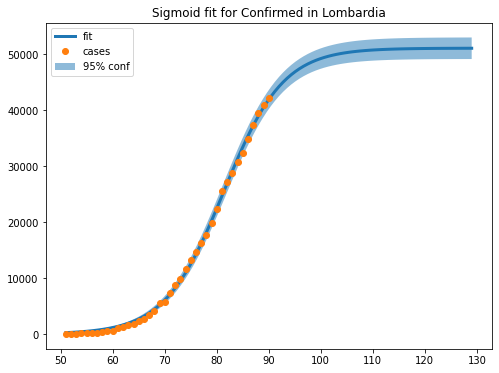

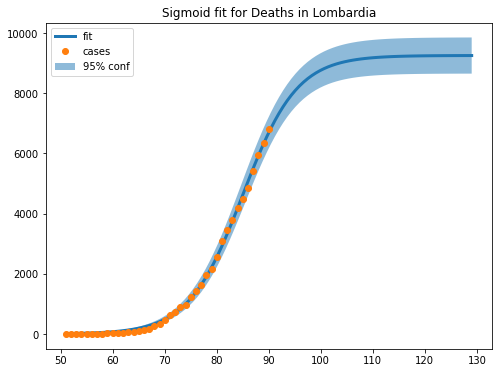

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


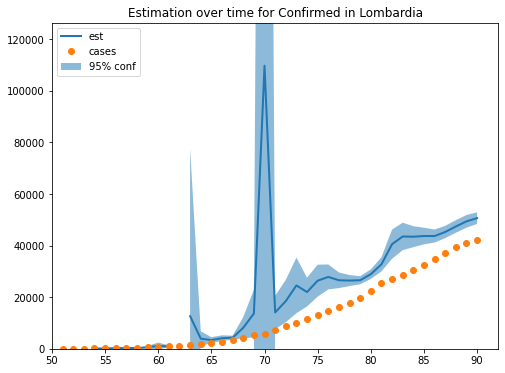

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


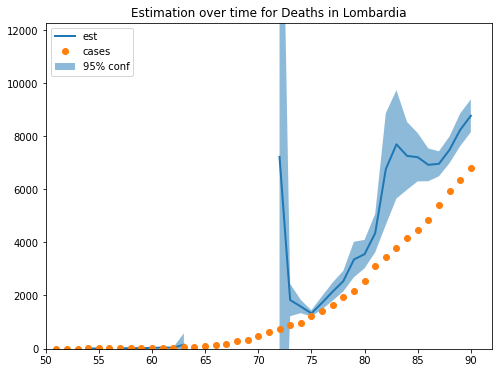

In [23]:
allPlots('Lombardia')

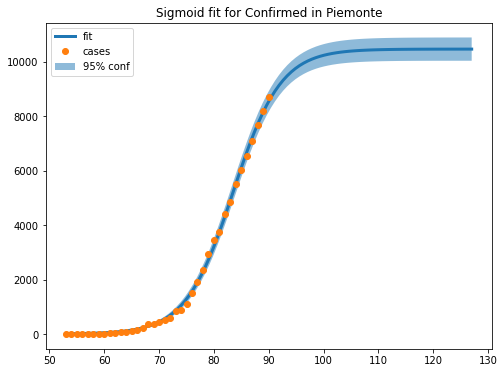

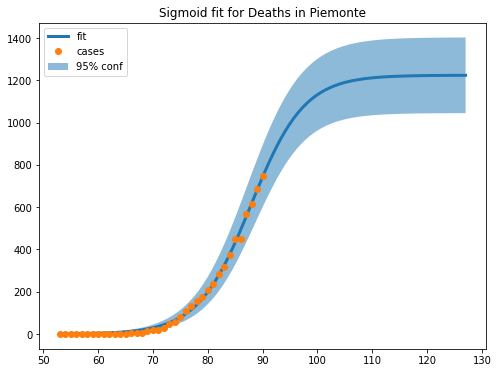

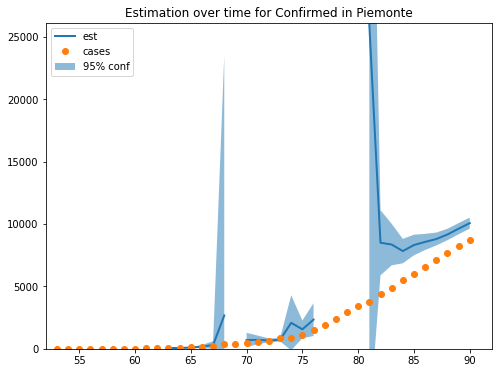

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


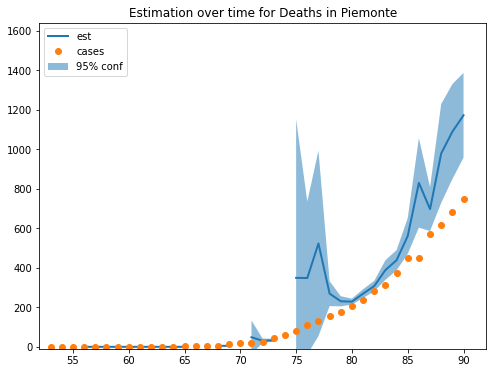

In [24]:
allPlots('Piemonte')

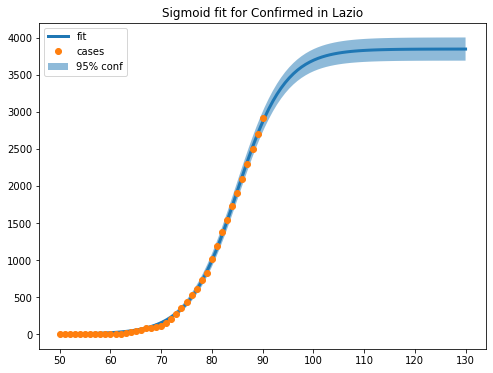

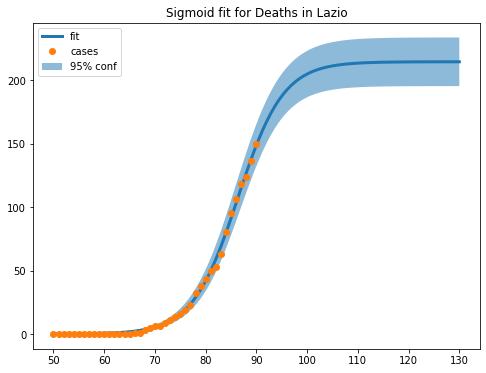

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


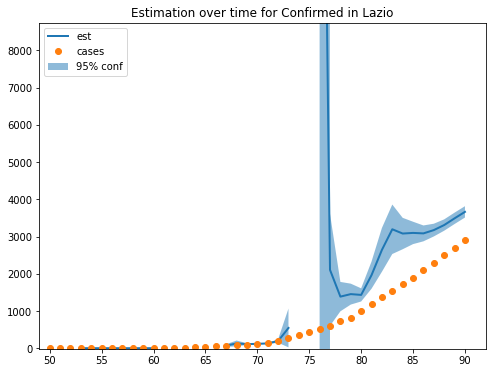

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


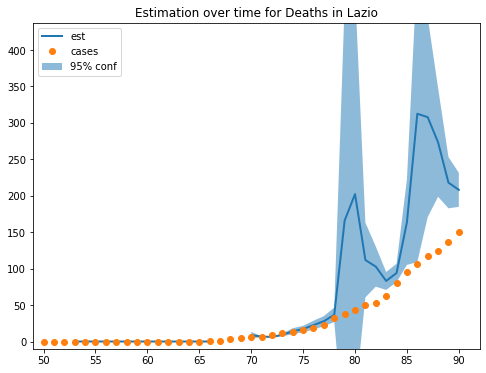

In [25]:
allPlots('Lazio')

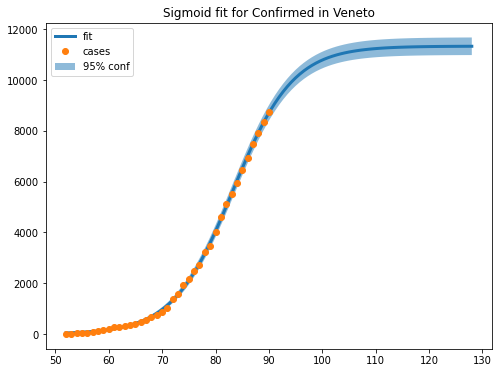

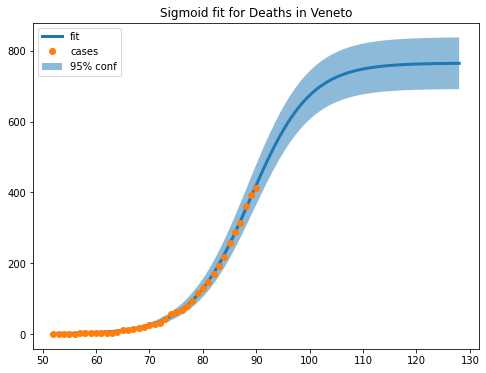

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


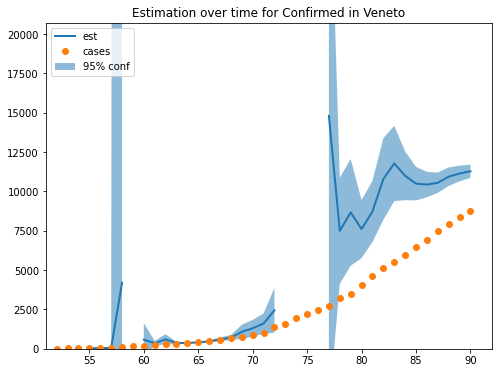

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


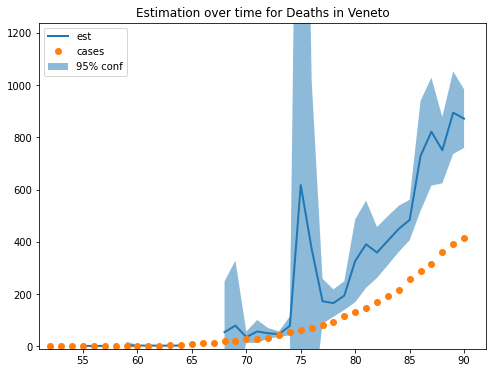

In [26]:
allPlots('Veneto')

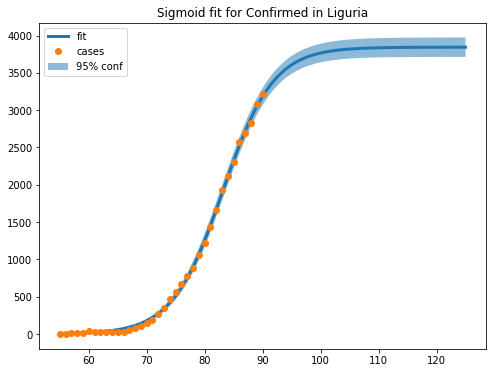

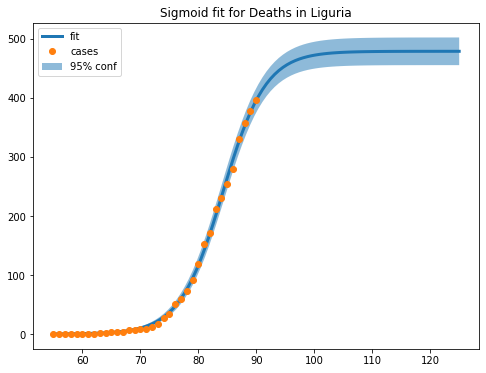

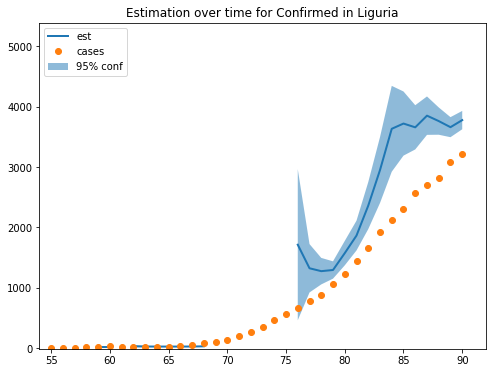

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


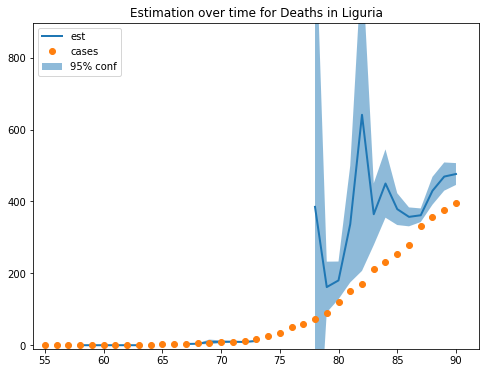

In [27]:
allPlots('Liguria')

In [28]:
regions = ts['Region'].unique()
regions

array(['Lazio', 'Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte',
       'P.A. Bolzano', "Valle d'Aosta", 'Umbria', 'Toscana', 'Sicilia',
       'Sardegna', 'Puglia', 'P.A. Trento', 'Marche', 'Molise',
       'Basilicata', 'Calabria', 'Campania', 'Abruzzo',
       'Friuli Venezia Giulia', 'Liguria'], dtype=object)

In [29]:
def plotRegions(regions, metric='Confirmed'):
    try:
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Compare regions with offset')

        for c in regions:
            try:
                pcov, perr = estimate(c)
                delay=int(pcov[0]-cRef[0])
                yM=pcov[1]
                x,y=regionData(c, metric)
                plt.plot(x-int(pcov[0]), y/yM, linewidth=2.0, label= "%s (%d days, max %.1fk)" % (c, delay, yM/1000)) 
            except:
                print('No fit for '+metric+' in '+c)

        plt.ylim(-0.1, 1.1)
        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+c)

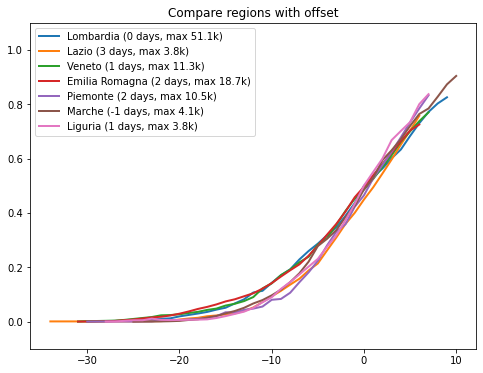

In [30]:
plotRegions(['Lombardia','Lazio','Veneto','Emilia Romagna','Piemonte','Marche','Liguria'])

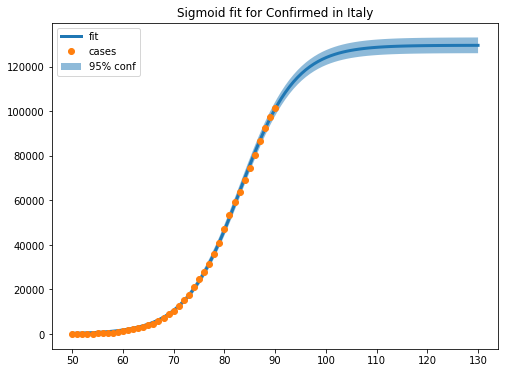

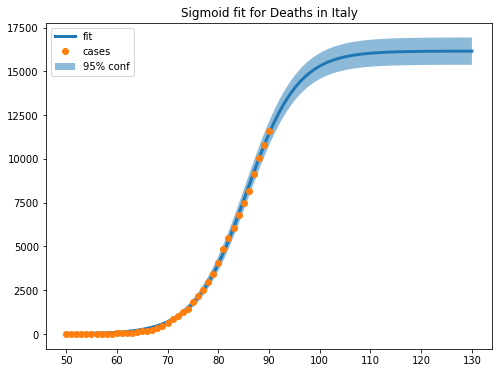

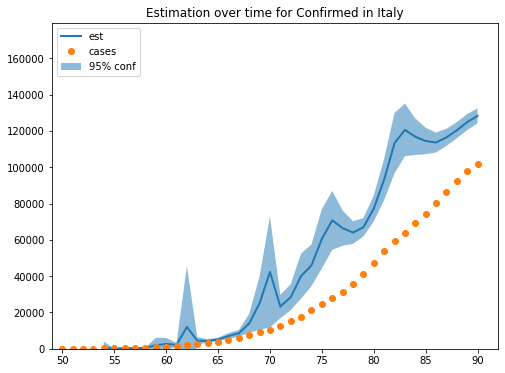

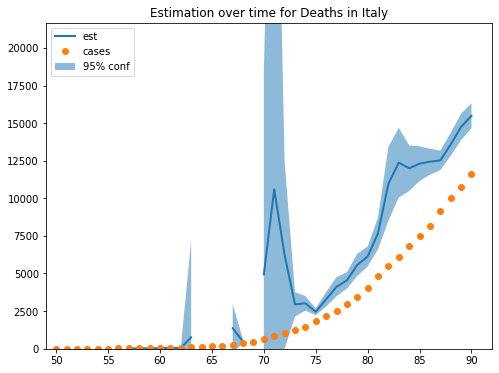

In [31]:
allPlots(None,'Italy')

In [82]:
def forecast(region, tolerance=0.99, leftcases=1, metric='Confirmed'):
    pcov, perr = estimate(region, metric)

    x0m, Lm, km = (pcov-perr*2)
    x0M, LM, kM = (pcov+perr*2)

    xm = logit(tolerance) / kM + x0m
    xM = logit(tolerance) / km + x0M

    #print (xm, xM)
    print("%.1f%% of %-9s in %-22s: " % (tolerance*100, metric, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))

    xm = logit((Lm-leftcases)/Lm) / kM + x0m
    xM = logit((LM-leftcases)/LM) / km + x0M

    #print (xm, xM)
    print("%3d %-9s left in %-22s: " % (leftcases, metric, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))


In [83]:
def allForecasts(region, tolerance=0.99, leftcases=1):
    forecast(region, tolerance, leftcases)
    forecast(region, tolerance, leftcases,'Deaths')

In [84]:
allForecasts('Lombardia')

99.0% of Confirmed in Lombardia             :  2020-04-14 2020-04-18
  1 Confirmed left in Lombardia             :  2020-05-18 2020-05-25
99.0% of Deaths    in Lombardia             :  2020-04-14 2020-04-18
  1 Deaths    left in Lombardia             :  2020-05-18 2020-05-25


In [78]:
for r in regions:
    forecast(r, 0.99)

99.0% of Confirmed in Lazio                 :  2020-04-14 2020-04-16
  1 Confirmed left in Lazio                 :  2020-04-30 2020-05-04
99.0% of Confirmed in Lombardia             :  2020-04-14 2020-04-18
  1 Confirmed left in Lombardia             :  2020-05-18 2020-05-25
99.0% of Confirmed in Veneto                :  2020-04-16 2020-04-19
  1 Confirmed left in Veneto                :  2020-05-12 2020-05-16
99.0% of Confirmed in Emilia Romagna        :  2020-04-18 2020-04-20
  1 Confirmed left in Emilia Romagna        :  2020-05-16 2020-05-21
99.0% of Confirmed in Piemonte              :  2020-04-11 2020-04-13
  1 Confirmed left in Piemonte              :  2020-04-30 2020-05-05
99.0% of Confirmed in P.A. Bolzano          :  2020-04-10 2020-04-17
  1 Confirmed left in P.A. Bolzano          :  2020-04-21 2020-05-02
99.0% of Confirmed in Valle d'Aosta         :  2020-04-02 2020-04-09
  1 Confirmed left in Valle d'Aosta         :  2020-04-07 2020-04-16
99.0% of Confirmed in Umbria      